<a href="https://colab.research.google.com/github/SergeySkopin/SergeyS_pet/blob/master/GuidedBP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import torch
import torch.nn as nn
from torchvision import transforms, models
from torchvision.models import resnet50, ResNet50_Weights
from torch.autograd import Variable
from skimage.io import imread
from PIL import Image
from skimage.transform import resize

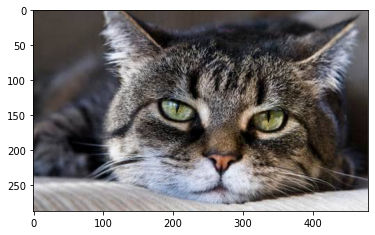

In [ ]:
#Загружаем свое изображение
image = Image.open("cat.jpg")
imshow(image)

In [ ]:

norm_data = transforms.Normalize(
   mean=[0.485, 0.456, 0.406],
   std=[0.229, 0.224, 0.225]
)

preprocess = transforms.Compose([
   transforms.Resize((224,224)),
   transforms.ToTensor(),
   norm_data
])

display = transforms.Compose([transforms.Resize((224,224))])
tensor = preprocess(image)
pred = Variable((tensor.unsqueeze(0)), requires_grad=True)

In [ ]:
test_model = models.resnet50(weights=ResNet50_Weights.IMAGENET1K_V1)
test_model.eval()

def prep_output(img_tensor):
    out = norm_data(img_tensor)[0]
    out = out.detach().numpy().transpose(1, 2, 0)

    return out

def relu_hook_function(module, grad_in, grad_out):
    if isinstance(module, torch.nn.ReLU):
        return (torch.clamp(grad_in[0], min=0.),)

for i, module in enumerate(test_model.modules()):
    if isinstance(module, torch.nn.ReLU):
        module.register_backward_hook(relu_hook_function)

def norm_flat_image(img):
    grads_norm = prep_output(img)
    grads_norm = grads_norm[:,:,0]+ grads_norm[:,:,1]+ grads_norm[:,:,2]

    grads_norm = (grads_norm - np.min(grads_norm))/ (np.max(grads_norm)- np.min(grads_norm))
    return grads_norm

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "


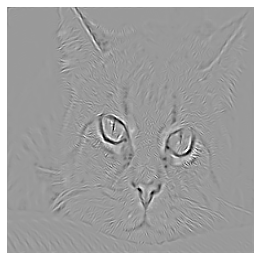

In [ ]:
out = test_model(pred)
loss = nn.CrossEntropyLoss()
input, target = out,torch.from_numpy(np.array([999]))
output_loss = loss(input,target).backward()
grads = pred.grad
plt.figure(figsize=(15,15))
plt.subplot(1,3,1)
plt.axis('off')
plt.imshow(norm_flat_image(grads),vmin=0.2, vmax=0.7, cmap="gray")
plt.show()